In [58]:
from transformers import BertForSequenceClassification, BertTokenizer
import transformers
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import shap
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import spacy

In [35]:
def predict(texts, model, tokenizer):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
    return probs.argmax(dim=-1).tolist(), probs

In [36]:
annotated_texts_df = pd.read_csv("annotated_texts_repr.csv", sep=",", encoding="utf-8")
annotated_texts_df['pop_sum'] = annotated_texts_df['pop_sum'].apply(lambda x: 0 if x < 2 else 1)
annotated_texts_df = annotated_texts_df.rename(columns={"pop_sum":"label"})

df_pop_train, df_pop_test = train_test_split(annotated_texts_df, test_size=0.25, stratify=annotated_texts_df['label'], random_state=42)
texts = list(df_pop_test["text"])
true_labels = list(df_pop_test["label"])

In [37]:
model_path = "finetuned_bin_pop_model"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [38]:
predictions, probs = predict(texts[:30], model, tokenizer)

correct_example = None
wrong_example = None

for i, (pred, true) in enumerate(zip(predictions, true_labels)):
    if pred == true and correct_example is None:
        correct_example = (texts[i], true, pred)
    elif pred != true and wrong_example is None:
        wrong_example = (texts[i], true, pred)
    if correct_example and wrong_example:
        break

print("Esempio classificato bene:", correct_example)
print("Esempio classificato male:", wrong_example)

Esempio classificato bene: ("IANNONE . Signor Presidente, onorevoli colleghi, rappresentanti del Governo, sinceramente non ci meraviglia che il Governo e la maggioranza siano su Marte (a questo ormai siamo abituati), ma che non sentano le grida provenienti dalla Terra. Noi affrontiamo un provvedimento molto complesso ed importante, che è stato ridotto ad uno spezzatino, con articoli che praticamente non sono stati trattati da questo ramo del Parlamento e con articoli modificati con accordi al ribasso. Un'unica cosa è stata fatta: è stata intrapresa una scelta politicamente criminale per Fratelli d'Italia, quella di decretare la morte di 30.000 imprese italiane. I nostri balneari hanno scritto una pagina della storia della nostra Nazione e sono un'eccellenza del mondo produttivo italiano, che ha resistito negli anni, ha resistito alla pandemia e ha resistito ai provvedimenti incomprensibili che sono stati emanati dal Governo anche durante il periodo della pandemia.  Noi non dobbiamo dim

In [39]:
def model_wrapper(masked_texts):
    masked_texts = np.array(masked_texts).tolist()
    inputs = tokenizer(masked_texts, padding=True, truncation=True, return_tensors="pt")
    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = F.softmax(outputs.logits, dim=-1).cpu().numpy()

    return probabilities

In [40]:
explainer = shap.Explainer(model_wrapper, tokenizer)
example_texts = [correct_example[0], wrong_example[0]]
shap_values = explainer(example_texts)

shap.plots.text(shap_values[0])
shap.plots.text(shap_values[1])

Token indices sequence length is longer than the specified maximum sequence length for this model (1339 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [17:55, 537.69s/it]


---

In [57]:
'''
with open("shap_explanation.pkl", "wb") as f:
    pickle.dump(shap_values, f)


with open("shap_explanation.pkl", "rb") as f:
    loaded_explanation = pickle.load(f)
'''

'\nwith open("shap_explanation.pkl", "wb") as f:\n    pickle.dump(shap_values, f)\n\n\nwith open("shap_explanation.pkl", "rb") as f:\n    loaded_explanation = pickle.load(f)\n'

In [45]:
tokens = shap_values.data[0]  #Estrazione token
token_shap_vals = shap_values.values[0][:, 1]  #Prendo i valori di Shap per la classe 1 (populista)

In [ ]:
#!python -m spacy download it_core_news_lg

In [46]:
nlp = spacy.load("it_core_news_lg")

In [55]:
def SHAP_by_sentences(text):
  doc = nlp(text)
  sentences = [sent.text.strip() for sent in doc.sents]

  sentence_shap = [0.0 for _ in sentences]
  sentence_counts = [0 for _ in sentences]

  sentence_boundaries = []
  start = 0
  for sent in sentences:
      end = start + len(sent)
      sentence_boundaries.append((start, end))
      start = end + 1

  current_pos = 0
  for token, val in zip(tokens, token_shap_vals):
      token = token.strip()
      if token == "":
          continue
      idx = text.find(token, current_pos)
      if idx == -1:
          continue
      current_pos = idx + len(token)
      for i, (start, end) in enumerate(sentence_boundaries):
          if start <= idx < end:
              sentence_shap[i] += val
              sentence_counts[i] += 1
              break

  sentence_avg_shap = [s/c if c > 0 else 0 for s, c in zip(sentence_shap, sentence_counts)]

  plt.figure(figsize=(10, 26))
  plt.barh(range(len(sentences)), sentence_avg_shap, align='center')
  plt.yticks(range(len(sentences)), sentences)
  plt.xlabel("Average SHAP Value")
  plt.title("Sentence-level SHAP Explanation")
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()

<ipython-input-52-00035c4ba8af>:43: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


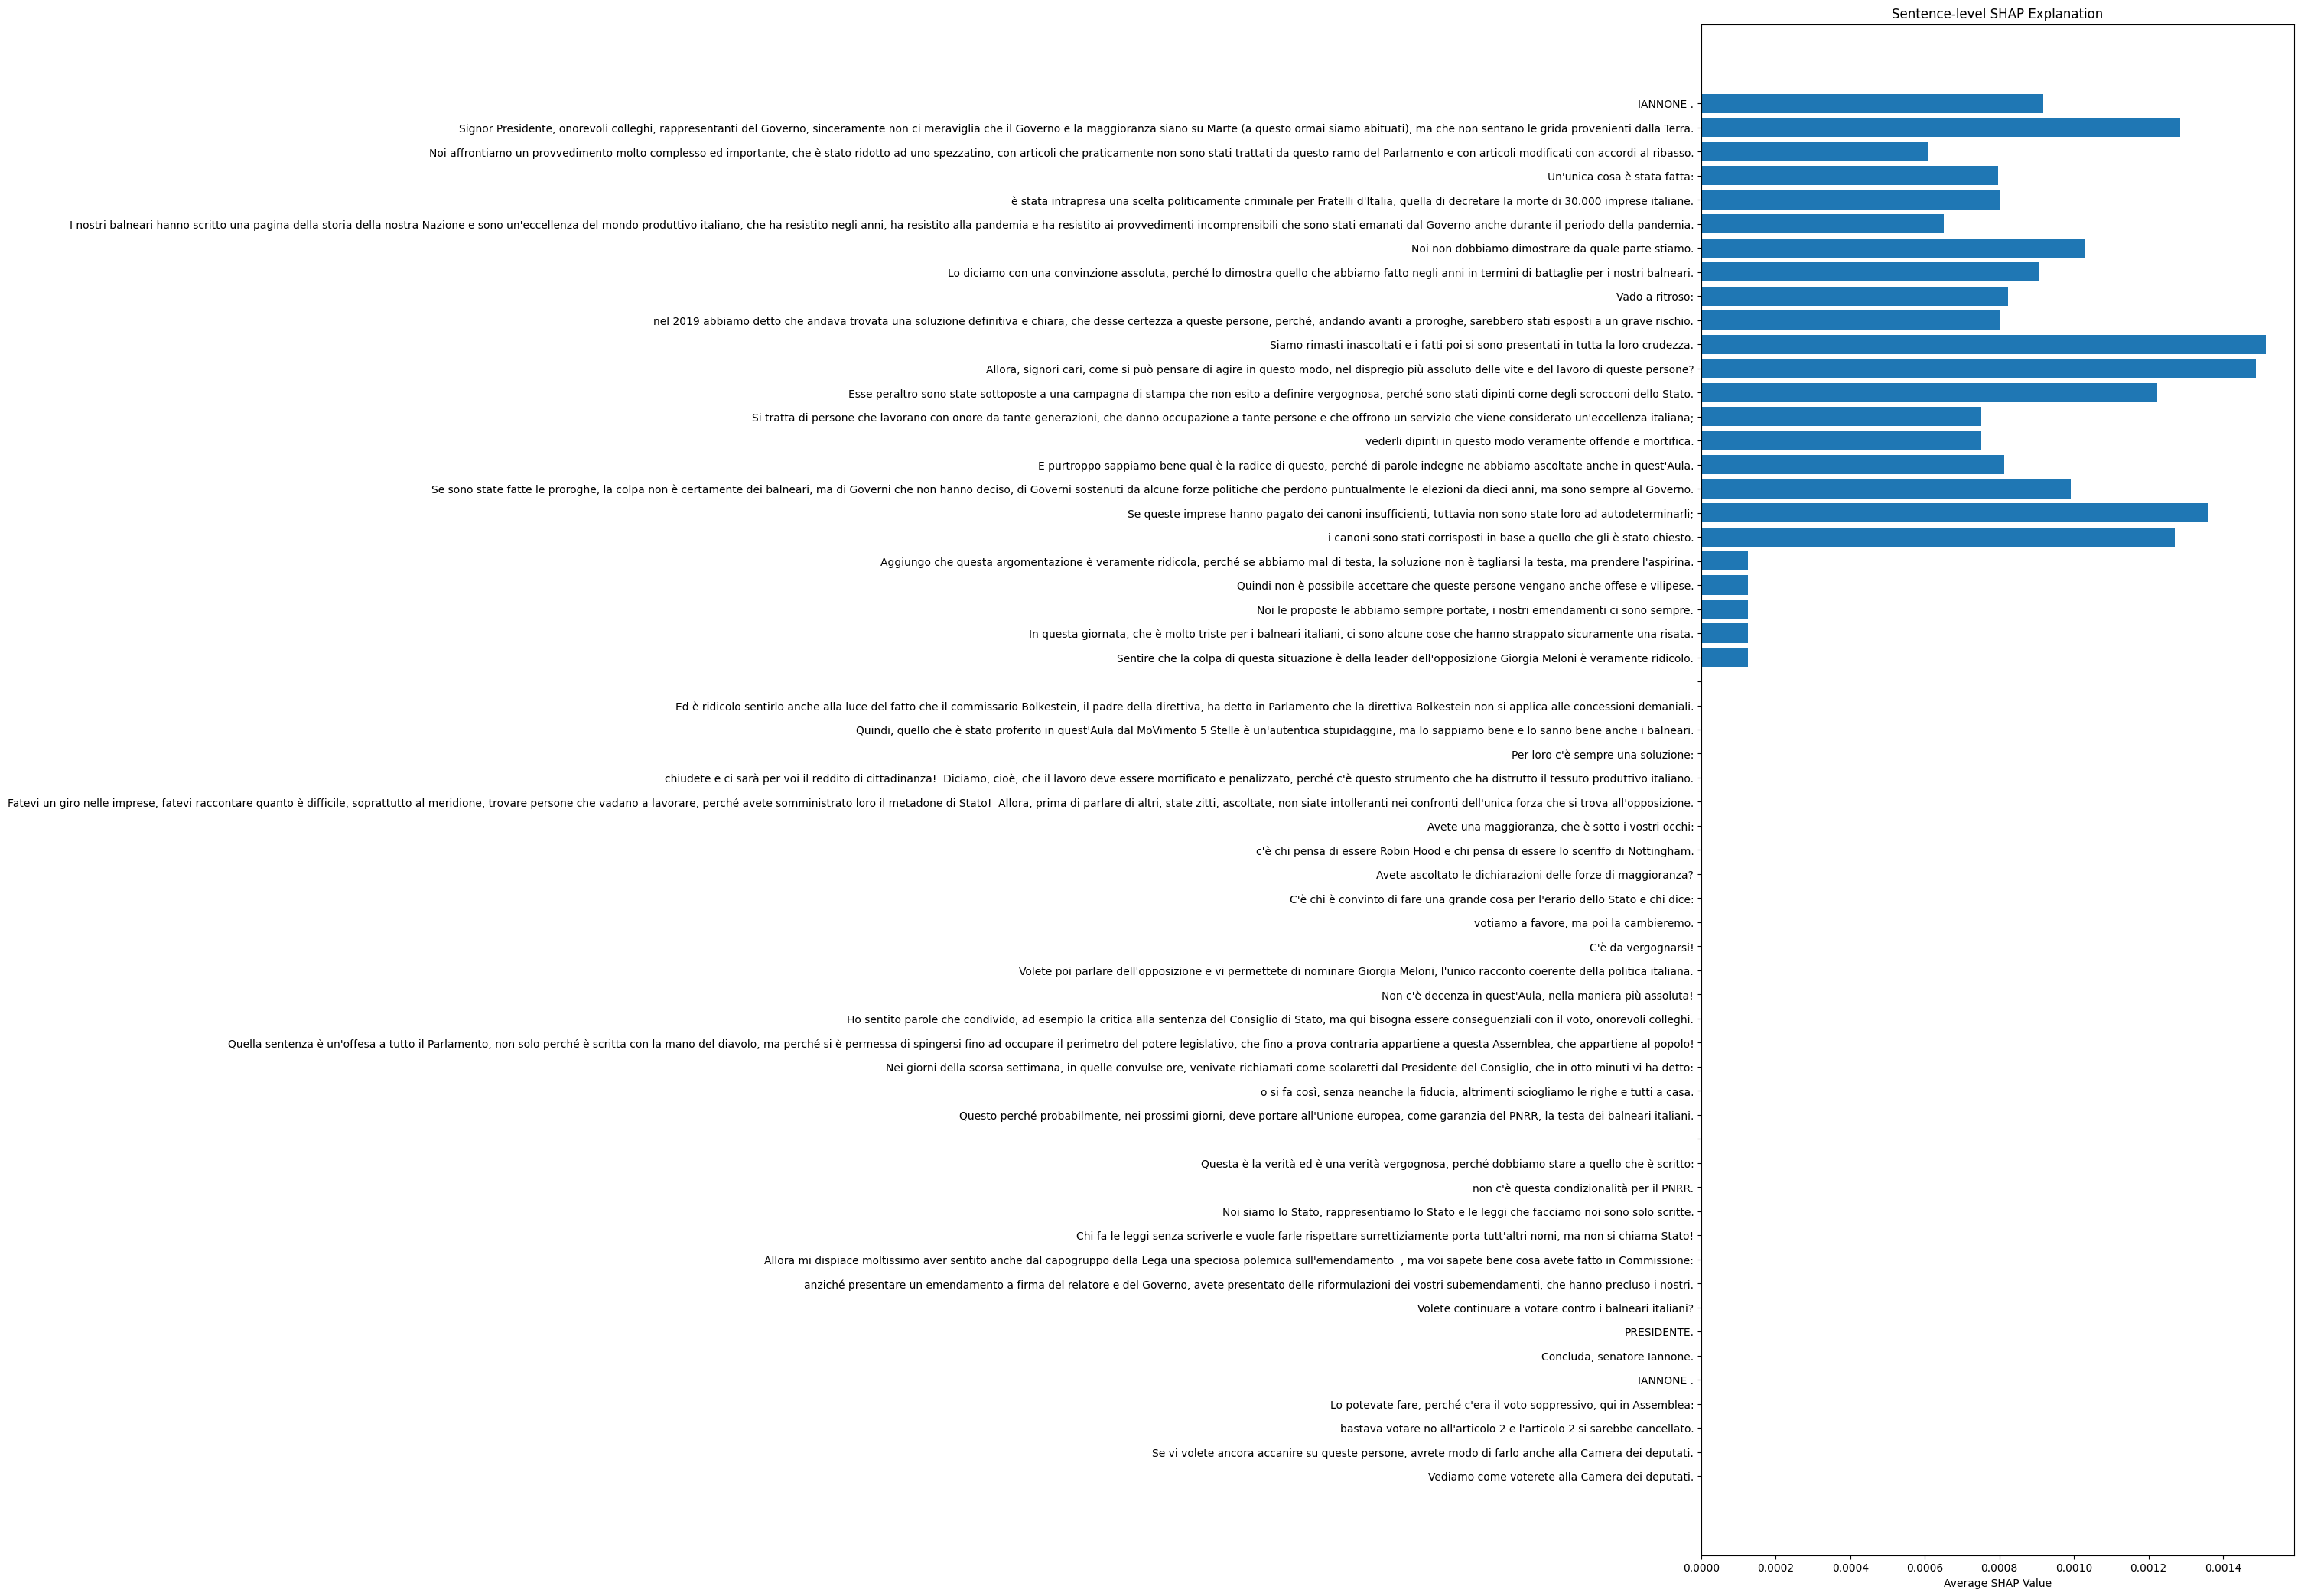

In [53]:
SHAP_by_sentences(correct_example[0])

<ipython-input-52-00035c4ba8af>:43: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


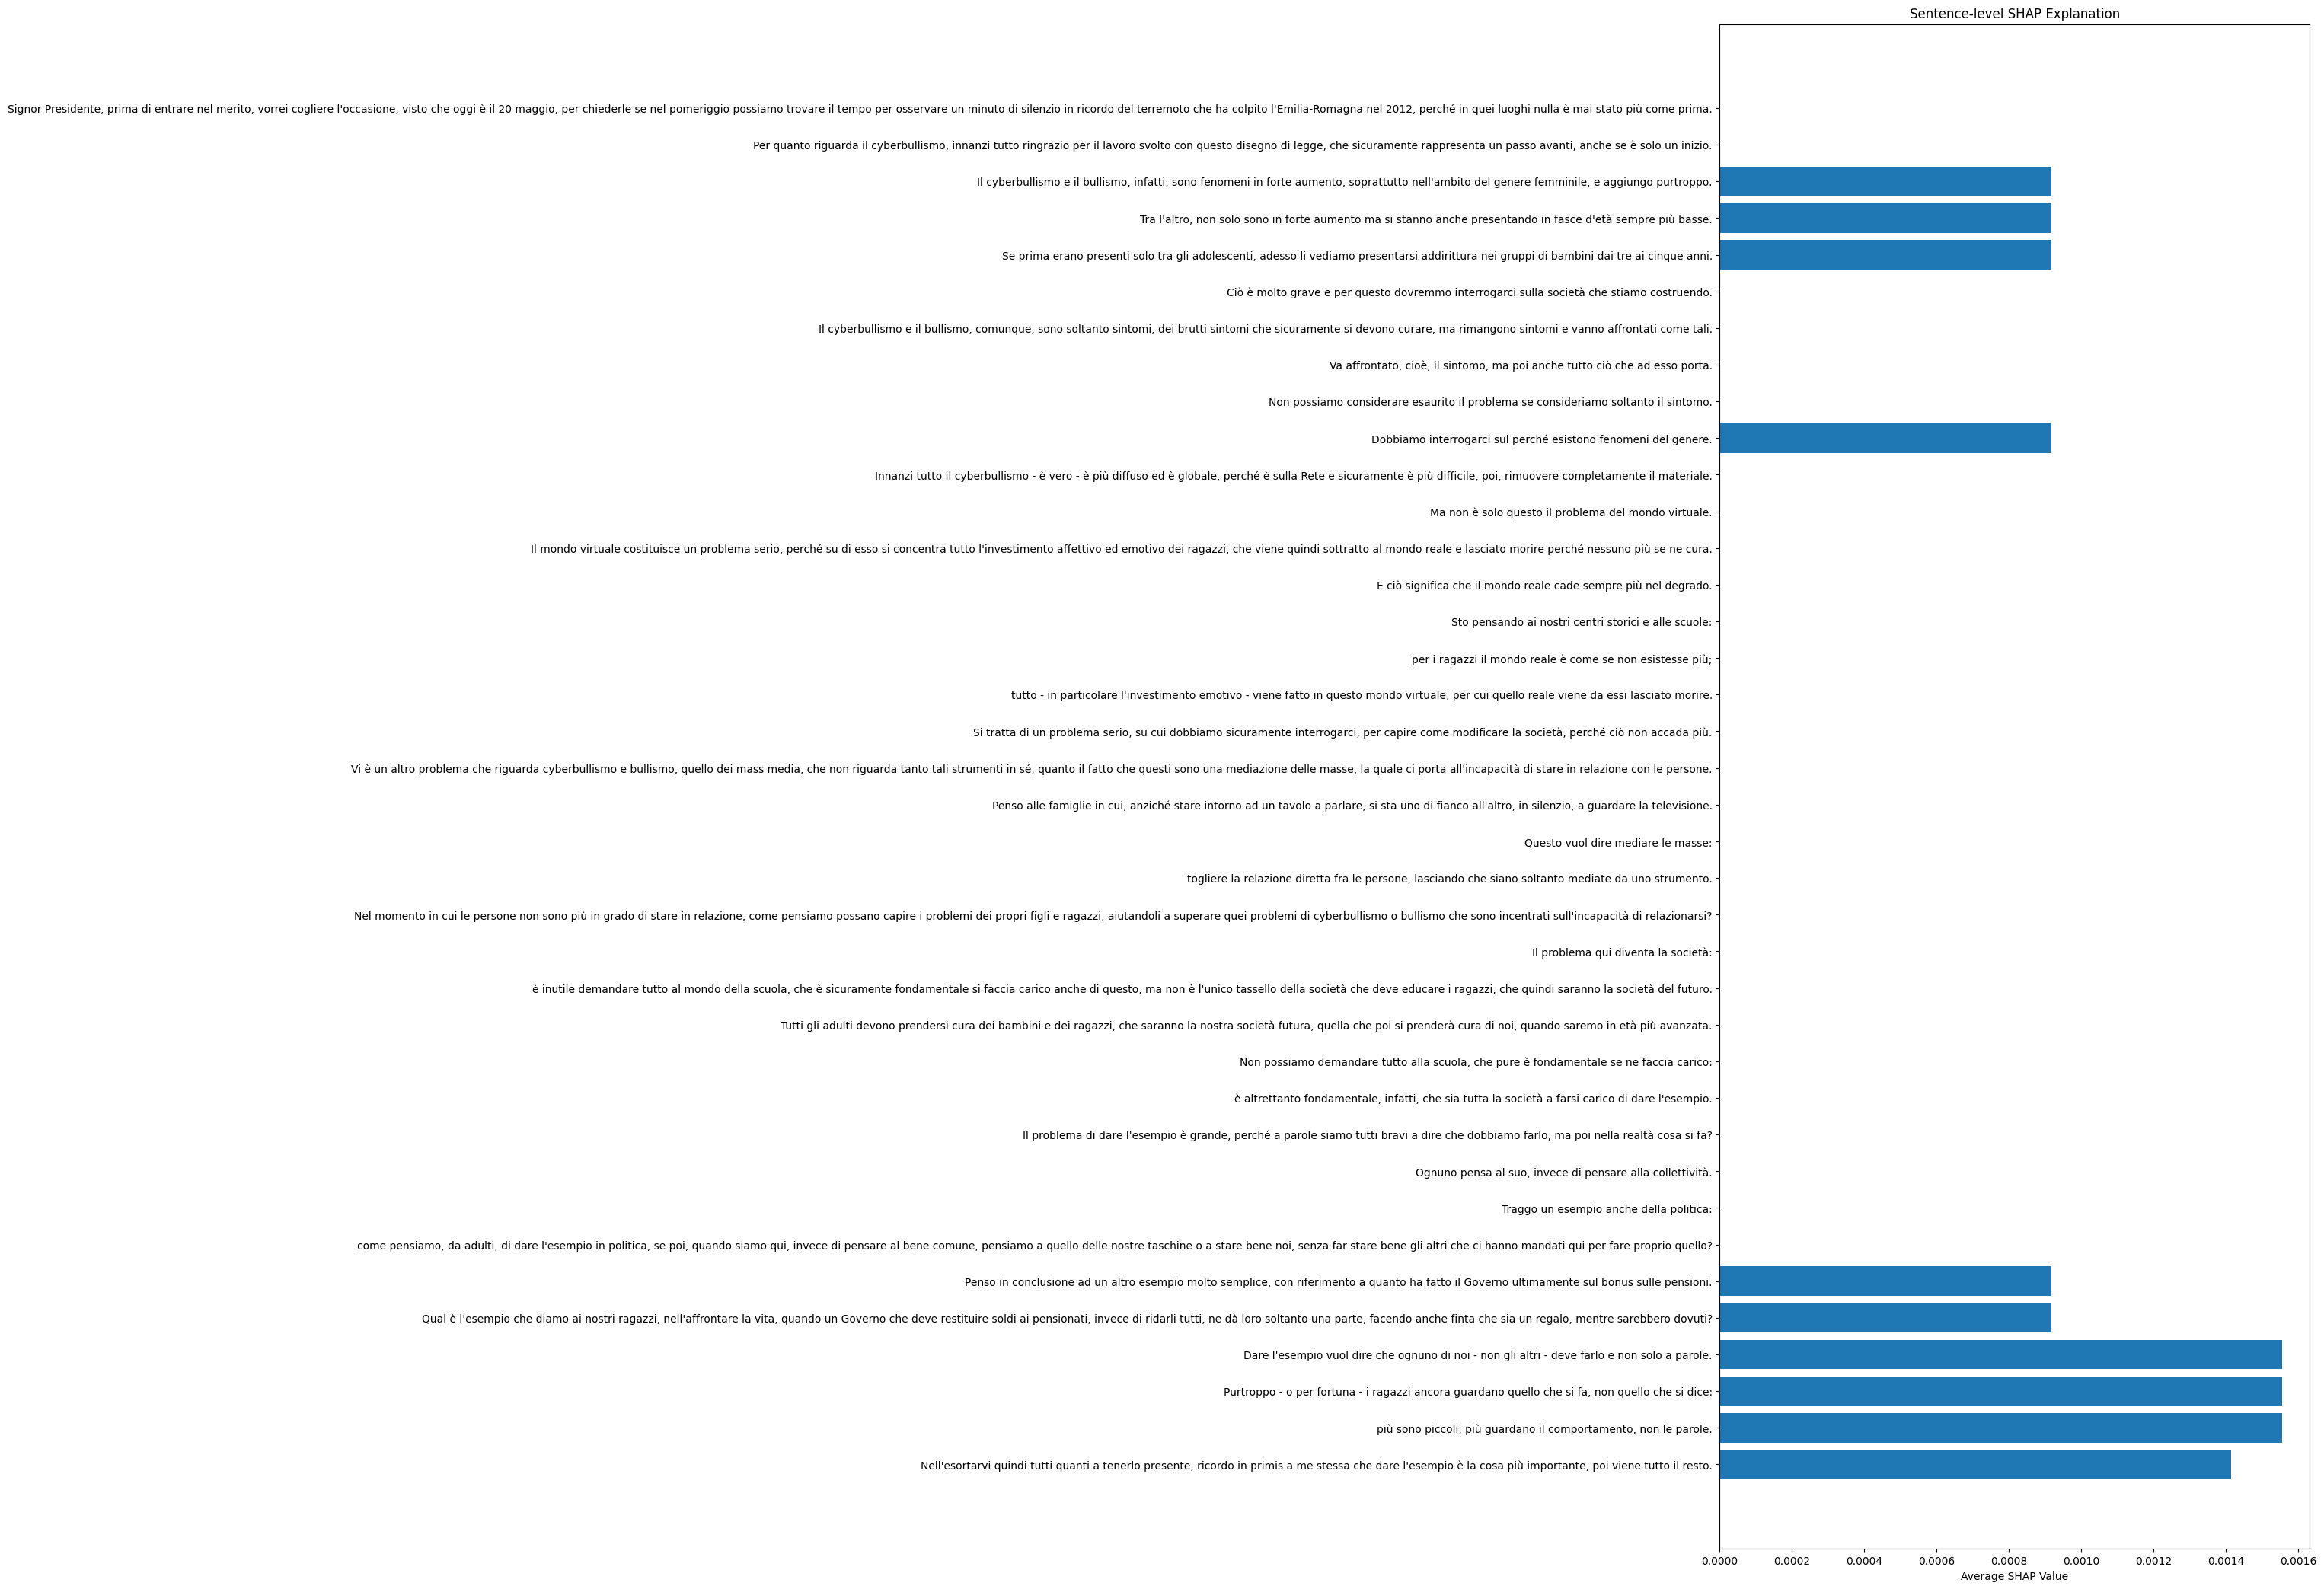

In [54]:
SHAP_by_sentences(wrong_example[0])

In [ ]:
tokens = shap_values.data[0]  #Estrazione token
shap_vals = shap_values.values[0][:, 1]  #Prendo i valori di Shap per la classe 1 (populista)

df = pd.DataFrame({'Token': tokens, 'SHAP Value': shap_vals})
df_sorted = df.sort_values(by="SHAP Value", ascending=False)

print(df_sorted.head(20))

             Token  SHAP Value
27           Marte    0.001554
25           siano    0.001554
26              su    0.001554
17              ci    0.001554
18      meraviglia    0.001554
19             che    0.001554
20              il    0.001554
21         Governo    0.001554
22               e    0.001554
23              la    0.001554
24     maggioranza    0.001554
16             non    0.001554
15    sinceramente    0.001554
269              l    0.001515
271              e    0.001515
265          Siamo    0.001515
274            poi    0.001515
275             si    0.001515
270           tati    0.001515
284              .    0.001515


In [ ]:
tokens = shap_values.data[1]  #Estrazione token
shap_vals = shap_values.values[1][:, 0]  #Prendo i valori di Shap per la classe 0 (non populista)

df = pd.DataFrame({'Token': tokens, 'SHAP Value': shap_vals})
df_sorted = df.sort_values(by="SHAP Value", ascending=False)

print(df_sorted.head(20))

            Token  SHAP Value
87            che    0.001936
88    sicuramente    0.001936
89    rappresenta    0.001936
90             un    0.001936
93              ,    0.001936
91          passo    0.001936
92         avanti    0.001936
67         quanto    0.001336
66            Per    0.001336
73              ,    0.001336
69             il    0.001336
68       riguarda    0.001336
70          cyber    0.001336
71            bul    0.001336
72          lismo    0.001336
190         sulla    0.001184
191       società    0.001184
194    costruendo    0.001184
193        stiamo    0.001184
189           rci    0.001184


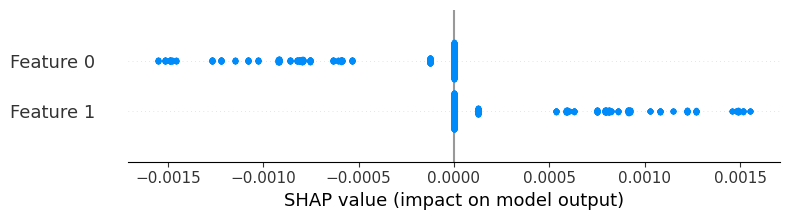

In [ ]:
shap.summary_plot(shap_values[0].values)

<ipython-input-41-e3acdeb517b8>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance[:60], y=sorted_words[:60], palette="viridis")


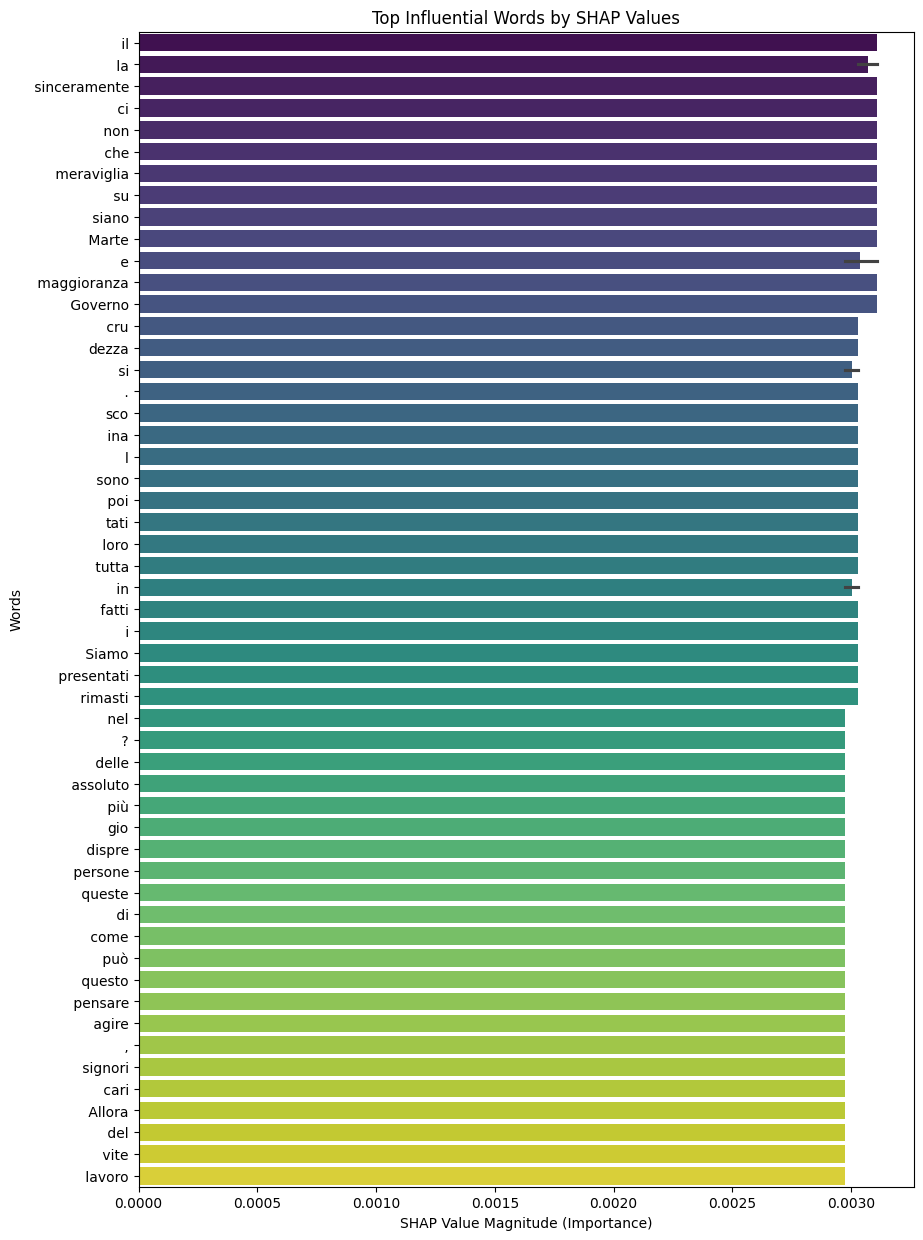

In [ ]:
words = shap_values.data[0] #Estraggo le parole

shap_importance = np.abs(shap_values.values[0]).sum(axis=1)  #Ottengo l'influenza in valore assoluto per ciascuna parola

#Ordino per influenza
sorted_indices = np.argsort(shap_importance)[::-1]
sorted_words = np.array(words)[sorted_indices]
sorted_importance = shap_importance[sorted_indices]

plt.figure(figsize=(10, 15))
sns.barplot(x=sorted_importance[:60], y=sorted_words[:60], palette="viridis")
plt.xlabel("SHAP Value Magnitude (Importance)")
plt.ylabel("Words")
plt.title("Top Influential Words by SHAP Values")
plt.show()